<a id="lib"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E91;overflow:hidden"><b>Importing Required Libraries</b></div> 

In [1]:
# For pySankey plot
!pip install pySankey -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# For using SafeML functions
!git clone https://github.com/ISorokos/SafeML.git

Cloning into 'SafeML'...
remote: Enumerating objects: 1944, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 1944 (delta 57), reused 123 (delta 54), pack-reused 1806
Receiving objects: 100% (1944/1944), 28.70 MiB | 23.16 MiB/s, done.
Resolving deltas: 100% (1098/1098), done.


In [3]:
import sys
sys.path.insert(1, './SafeML/Implementation_in_Python')

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

<a id="read_data"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Reading the GTSRB Dataset</b></div> 

Reading the input images and putting them into a numpy array.

In [5]:
data=[]
labels=[]

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height * width*channels

for i in range(classes) :
    path = "../input/gtsrb-german-traffic-sign/Train/{0}/".format(i)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

../input/gtsrb-german-traffic-sign/Train/0/
../input/gtsrb-german-traffic-sign/Train/1/
../input/gtsrb-german-traffic-sign/Train/2/
../input/gtsrb-german-traffic-sign/Train/3/
../input/gtsrb-german-traffic-sign/Train/4/
../input/gtsrb-german-traffic-sign/Train/5/
../input/gtsrb-german-traffic-sign/Train/6/
../input/gtsrb-german-traffic-sign/Train/7/
../input/gtsrb-german-traffic-sign/Train/8/
../input/gtsrb-german-traffic-sign/Train/9/
../input/gtsrb-german-traffic-sign/Train/10/
../input/gtsrb-german-traffic-sign/Train/11/
../input/gtsrb-german-traffic-sign/Train/12/
../input/gtsrb-german-traffic-sign/Train/13/
../input/gtsrb-german-traffic-sign/Train/14/
../input/gtsrb-german-traffic-sign/Train/15/
../input/gtsrb-german-traffic-sign/Train/16/
../input/gtsrb-german-traffic-sign/Train/17/
../input/gtsrb-german-traffic-sign/Train/18/
../input/gtsrb-german-traffic-sign/Train/19/
../input/gtsrb-german-traffic-sign/Train/20/
../input/gtsrb-german-traffic-sign/Train/21/
../input/gtsrb-germa

<a id="split"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Separating Train, Test and Validation Data</b></div> 
 
In this section, 20% of data is separated for test and validation and the rest is used for training. This section can be improved using methods like K-fold cross-validation. We tried to make it as simple as possible.

In [6]:
#Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

<a id="model"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining the CNN Model</b></div> 

Here the CNN model's structure is defined. Regarding the loss function the categorical crossentropy is used, and the ADAM is selection for the network optimization.

In [7]:
#Definition of the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

<a id="train"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Training the Model and Calculating its Accuracy</b></div> 

In this section, the CNN model is trained and the accuracy plot is shown. 

Epoch 1/20
981/981 [==============================] - 63s 64ms/step - loss: 1.2032 - accuracy: 0.6528 - val_loss: 0.1577 - val_accuracy: 0.9656
Epoch 2/20
981/981 [==============================] - 61s 62ms/step - loss: 0.2115 - accuracy: 0.9366 - val_loss: 0.0428 - val_accuracy: 0.9904
Epoch 3/20
981/981 [==============================] - 61s 63ms/step - loss: 0.1250 - accuracy: 0.9631 - val_loss: 0.0227 - val_accuracy: 0.9952
Epoch 4/20
981/981 [==============================] - 61s 63ms/step - loss: 0.0958 - accuracy: 0.9720 - val_loss: 0.0210 - val_accuracy: 0.9948
Epoch 5/20
981/981 [==============================] - 62s 63ms/step - loss: 0.0747 - accuracy: 0.9780 - val_loss: 0.0232 - val_accuracy: 0.9946
Epoch 6/20
981/981 [==============================] - 62s 63ms/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.0200 - val_accuracy: 0.9953
Epoch 7/20
981/981 [==============================] - 62s 63ms/step - loss: 0.0569 - accuracy: 0.9813 - val_loss: 0.0145 - val_accuracy:

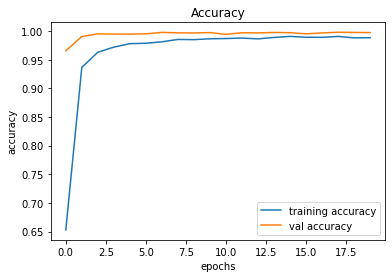

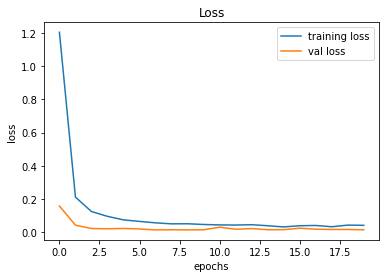

In [8]:
#using ten epochs for the training and saving the accuracy for each epoch
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val))

#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

<a id="test"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Testing the Model</b></div> 

Having trained the CNN model, the test data is used. The predicted decisions has been stored as "y_pred". As can be seen the accuracy of the model is about 0.97%.

In [9]:
#Predicting with the test data
y_test=pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
# labels=y_test['Path'].as_matrix()
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('../input/gtsrb-german-traffic-sign/Test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 
y_pred = model.predict_classes(X_test)

#Accuracy with the test data
from sklearn.metrics import accuracy_score

print(y_pred)

accuracy_score(y_test, y_pred)

[16  1 38 ... 32  7 10]


0.973950910530483

<a id="acc_pysankey"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Visualizing the Confusion Matrix using Sankey Plot</b></div> 

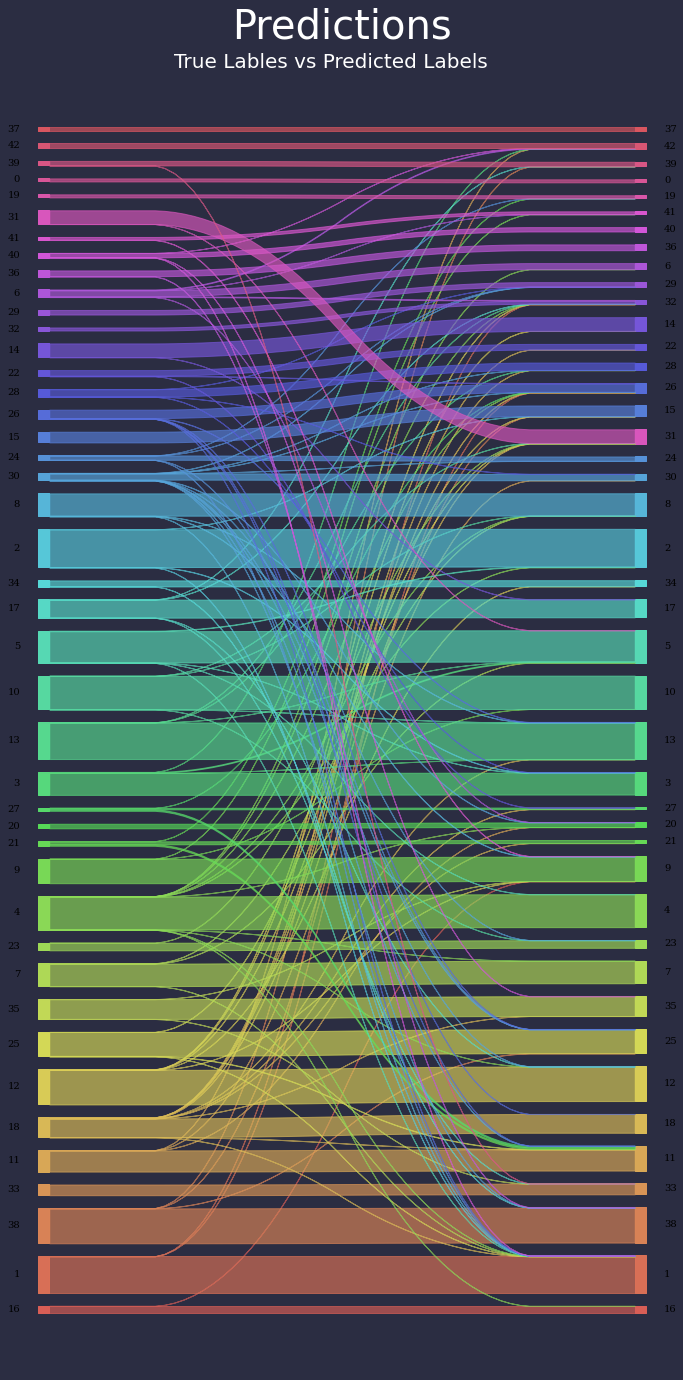

In [10]:
from pySankey.sankey import sankey

sankey(
    left=y_test, 
    right=y_pred, 
#     leftWeight= df_got["Season"], 
#     rightWeight=df_got["Season"], 
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 24)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

#font color to white
plt.rcParams['text.color'] = 'white'

plt.rcParams['axes.titlecolor'] = 'white'

plt.rcParams['axes.labelcolor'] = 'white'

#Font to Trebuchet MS
plt.rcParams['font.family'] = 'Trebuchet MS'

#font size to 12
plt.rcParams['font.size'] = 30

#Title
plt.title("Predictions", fontsize=40, fontname='Trebuchet MS', pad=30)
#subtitle 
plt.suptitle("True Lables vs Predicted Labels", fontsize=20, fontname='Trebuchet MS', y=0.889)

fig.savefig("True_vs_Wrong1.png", bbox_inches="tight", dpi=800)

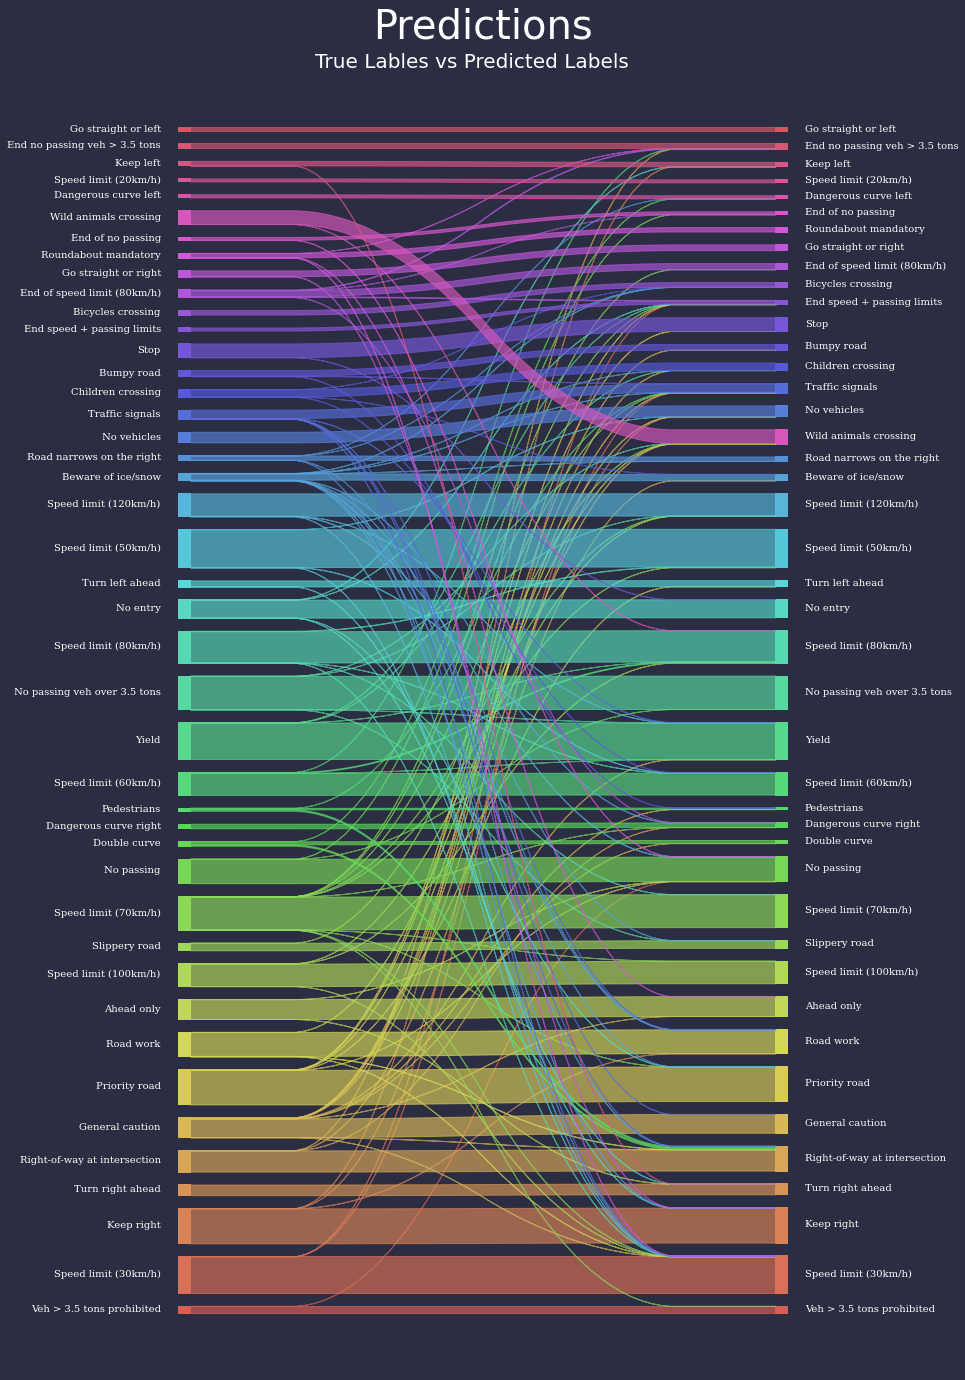

In [11]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Predictions_df = pd.DataFrame()
Predictions_df['True'] = y_test
Predictions_df['Pred'] = y_pred

Predictions_df['True'] = Predictions_df['True'].map(classes)
Predictions_df['Pred'] = Predictions_df['Pred'].map(classes)
Predictions_df.head()

sankey(
    left  = Predictions_df['True'], 
    right = Predictions_df['Pred'], 
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 24)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

#font color to white
plt.rcParams['text.color'] = 'white'

plt.rcParams['axes.titlecolor'] = 'white'

plt.rcParams['axes.labelcolor'] = 'white'

plt.rcParams['axes.labelsize'] = 'large'

#Font to Trebuchet MS
plt.rcParams['font.family'] = 'Trebuchet MS'

#font size to 12
plt.rcParams['font.size'] = 30

#Title
plt.title("Predictions", fontsize=40, fontname='Trebuchet MS', pad=30)
#subtitle 
plt.suptitle("True Lables vs Predicted Labels", fontsize=20, fontname='Trebuchet MS', y=0.889)

fig.savefig("True_vs_Pred.png", bbox_inches="tight", dpi=800)

<a id="safeml"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>SafeML: Safety Monitoring through Statistical Distance Measure</b></div> 

     |████████████████████████████████| 8.5 MB 493 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
0.37077944280077546
0.03764040420663517
-0.2167194148862568


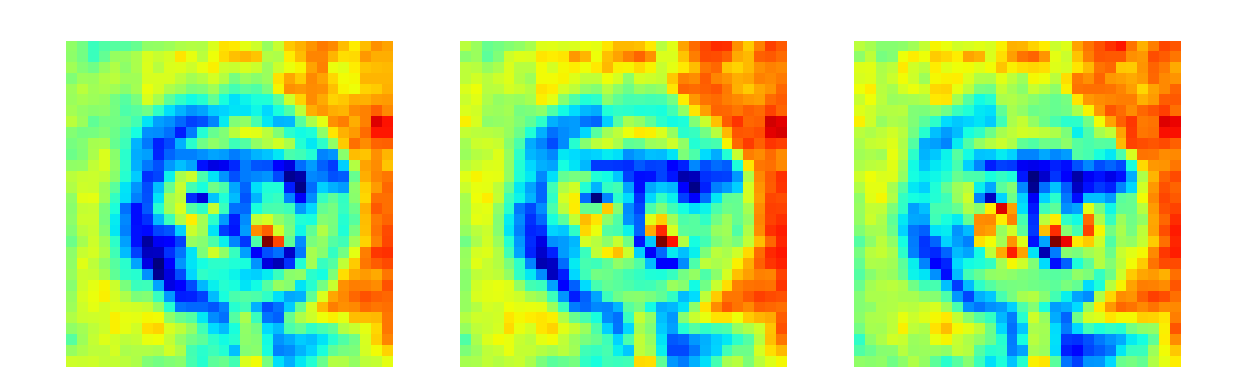

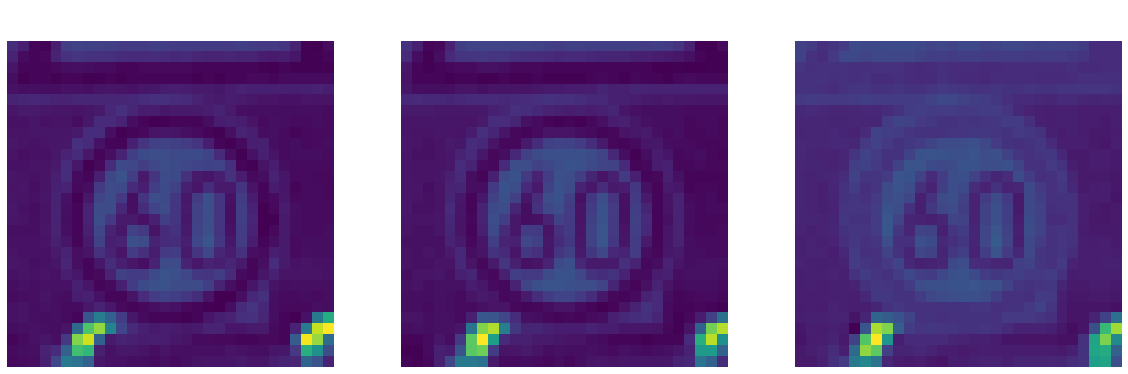

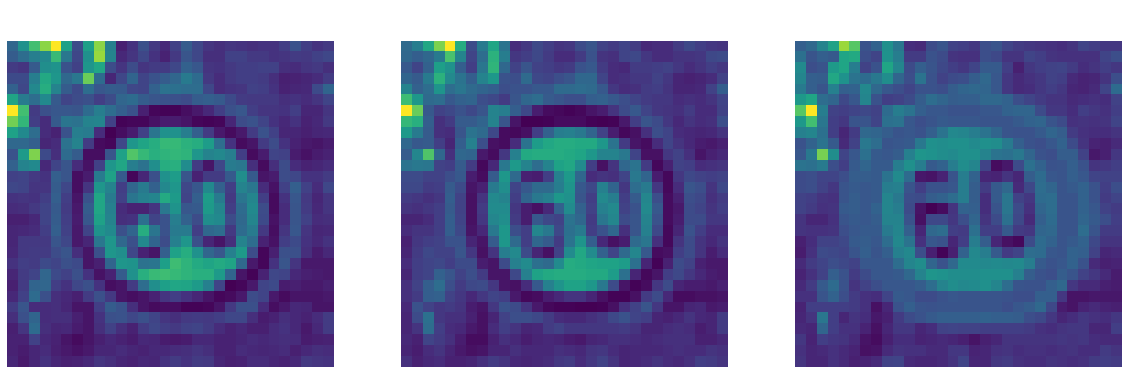

In [12]:
# Safety Monitoring through Statistical Parametric Mapping
!pip install spm1d
import os
from matplotlib import pyplot
import spm1d

# Separating Wrong Responses of the CNN Classifier
X_test_wrong, y_test_wrong = X_test[np.where(y_test != y_pred)], y_test[np.where(y_test != y_pred)]

# print(X_test_wrong.shape)

# Finding Wrong Decisions for Label 2 (just an example)
X_test_wrong3, y_test_wrong3 = X_test_wrong[np.where(y_test_wrong == 3)], y_test_wrong[np.where(y_test_wrong == 3)]

# print(X_test_wrong1.shape)

X_train3 = X_train[np.where(y_train[:,3] == 1)]


fig2, ax6 = pyplot.subplots(1,3, figsize = (20,6))

for ii, c_ax in enumerate(ax6.flatten()):
    # Comparing X_train for Label == 2 with X_Test_wronge for Label == 2
    xxx, yyy= X_train3[:,:,:,ii], X_test_wrong3[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    snpm    = spm1d.stats.nonparam.ttest2(xxx_2[:30], yyy_2[:30])
    snpmi   = snpm.inference(0.05, two_tailed=True, iterations=1000) # Alpha is considered as 0.05
    
   # print(xxx_2.shape)
    J,Q     = xxx_2.shape
    z       = snpmi.z
    zstar   = snpmi.zstar
    z0      = np.zeros(Q)
    z0      = z
    Z0      = np.reshape(z0, (30,30))
    Z0i     = Z0.copy()
    Z0i[np.abs(Z0i)<zstar] = 0
    ZZ      = np.hstack( [Z0, Z0i] )
    
    print(1 - z[z != 0].mean())
    
    c_ax.imshow(Z0, 'jet') # Can be replaced with Z0i
    c_ax.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax.axis('off')

fig3, ax7 = pyplot.subplots(1,3, figsize = (20,6))    

for ii, c_ax in enumerate(ax7.flatten()):
    c_ax.imshow(X_train3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, 3))
    c_ax.axis("off")
    
fig4, ax8 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax in enumerate(ax8.flatten()):
    c_ax.imshow(X_test_wrong3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test_wrong3[1]))
    c_ax.axis('off')

<a id="safeml"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Safety Monitoring through Statistical Parametric Mapping (SPM)</b></div>


900
900
900


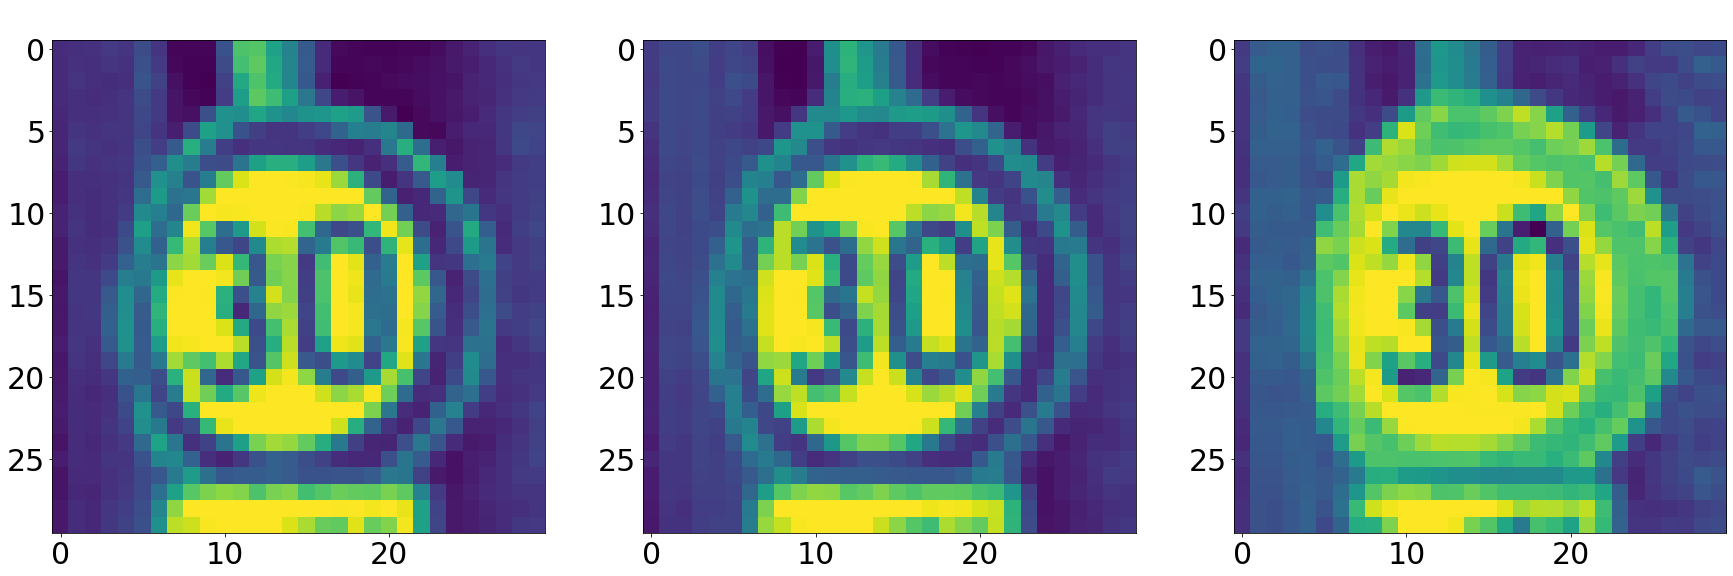

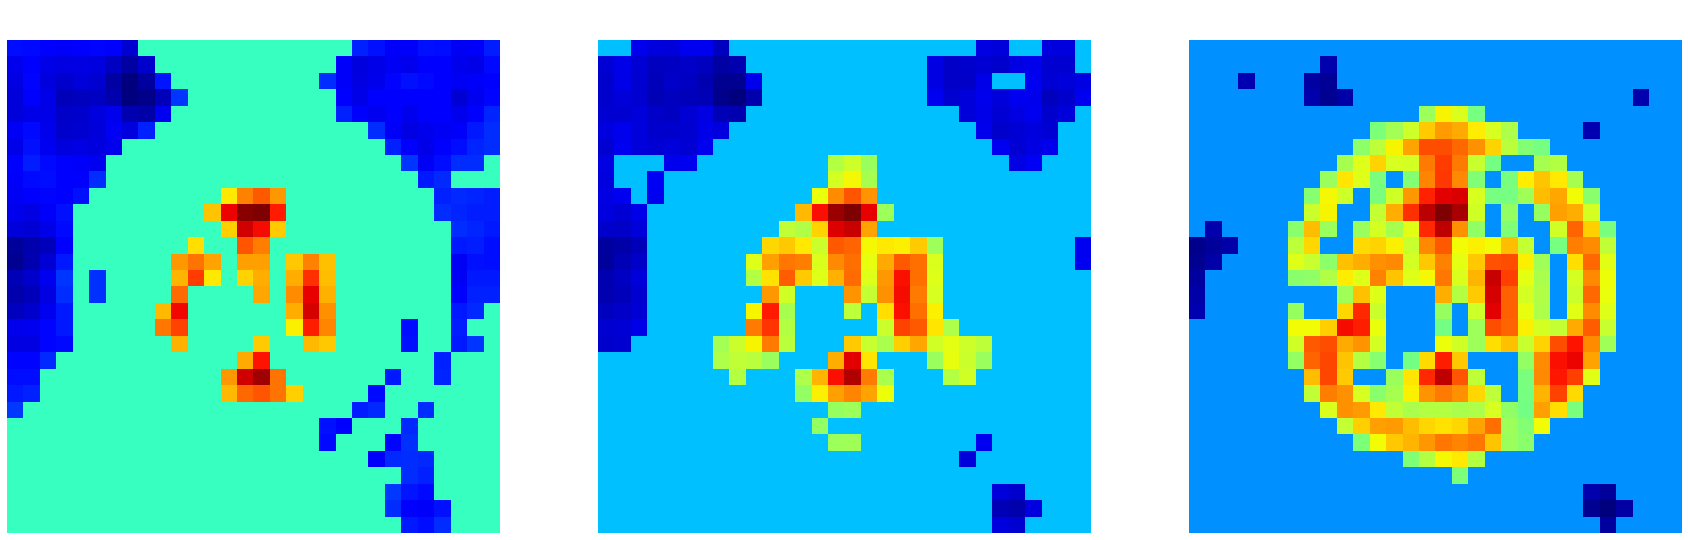

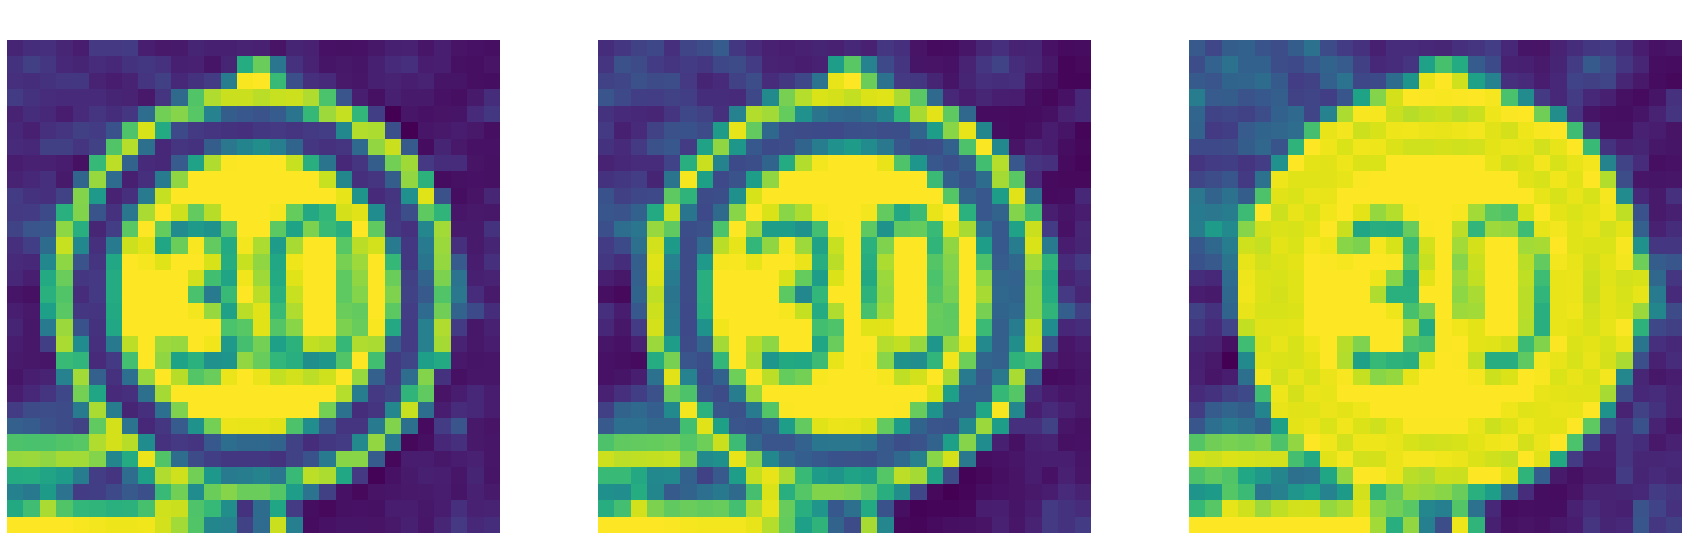

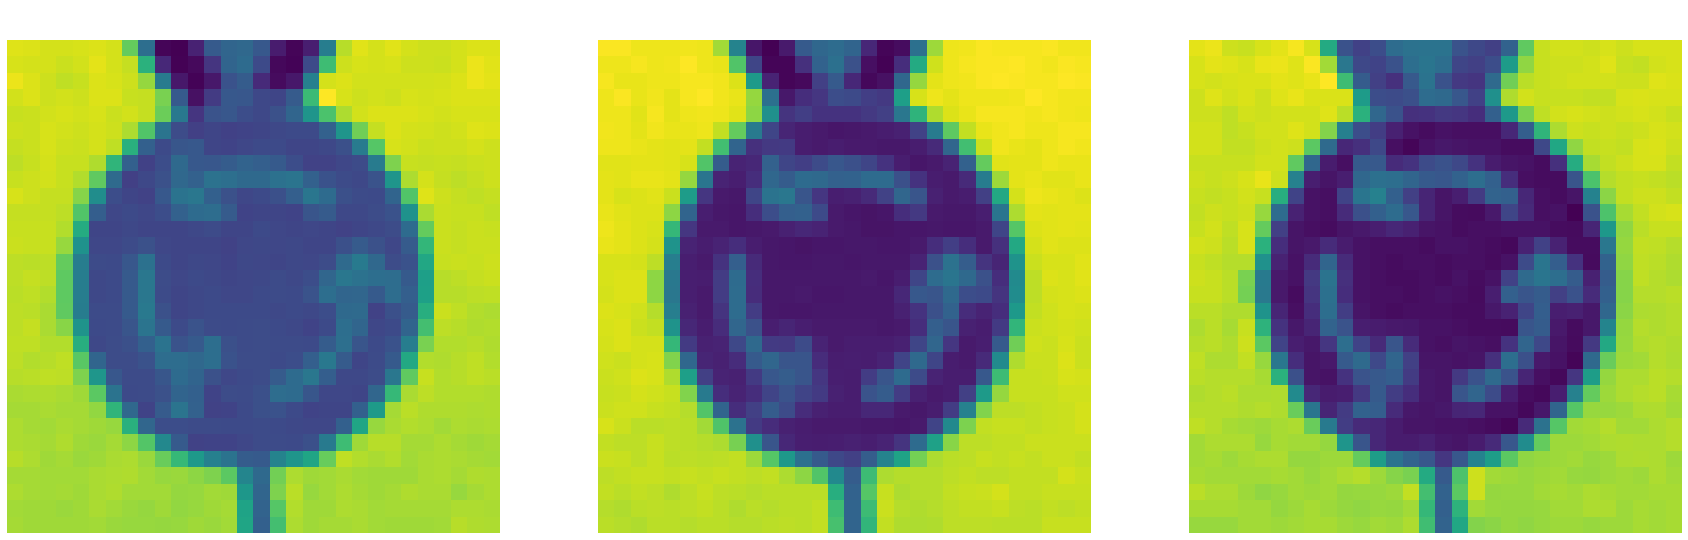

In [13]:
import os
from matplotlib import pyplot
import spm1d

fig, ax1 = plt.subplots(1,3, figsize = (30,12))

for ii, c_ax in enumerate(ax1.flatten()):
    c_ax.imshow(X_test[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test[1]))
    
X_train1, y_train1 = X_train[np.where(y_train[2,:] == 1)], y_train[np.where(y_train[2,:] == 1)]
X_test1, y_test1 = X_test[np.where(y_test == 1)], y_test[np.where(y_test == 1)]
X_test1_pred, y_test1_pred = X_test[np.where(y_pred == 40)], y_test[np.where(y_pred == 40)]

# print(X_test1.shape)

fig2, ax2 = pyplot.subplots(1,3, figsize = (30,10))

for ii, c_ax in enumerate(ax2.flatten()):
    xxx, yyy= X_test1[:,:,:,ii], X_test1_pred[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    snpm    = spm1d.stats.nonparam.ttest2(xxx_2[:30], yyy_2[:30])
    snpmi   = snpm.inference(0.01, two_tailed=True, iterations=1000)
    
    print(xxx_2.shape[1])
    J,Q     = xxx_2.shape
    z       = snpmi.z
    zstar   = snpmi.zstar
    z0      = np.zeros(Q)
    z0      = z
    Z0      = np.reshape(z0, (30,30))
    Z0i     = Z0.copy()
    Z0i[np.abs(Z0i)<zstar] = 0
    ZZ      = np.hstack( [Z0, Z0i] )
    
    c_ax.imshow(Z0i, 'jet')
    c_ax.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax.axis('off')

fig3, ax3 = pyplot.subplots(1,3, figsize = (30,10))    

for ii, c_ax in enumerate(ax3.flatten()):
    c_ax.imshow(X_test1[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test1[1]))
    c_ax.axis('off')
    
fig4, ax4 = pyplot.subplots(1,3, figsize = (30,10))     

for ii, c_ax in enumerate(ax4.flatten()):
    c_ax.imshow(X_test1_pred[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test1_pred[1]))
    c_ax.axis('off')

<a id="wd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Wasserstein Distance Measure</b></div> 

0.9147655334114889
0.9086625155666251
0.9571416430594901


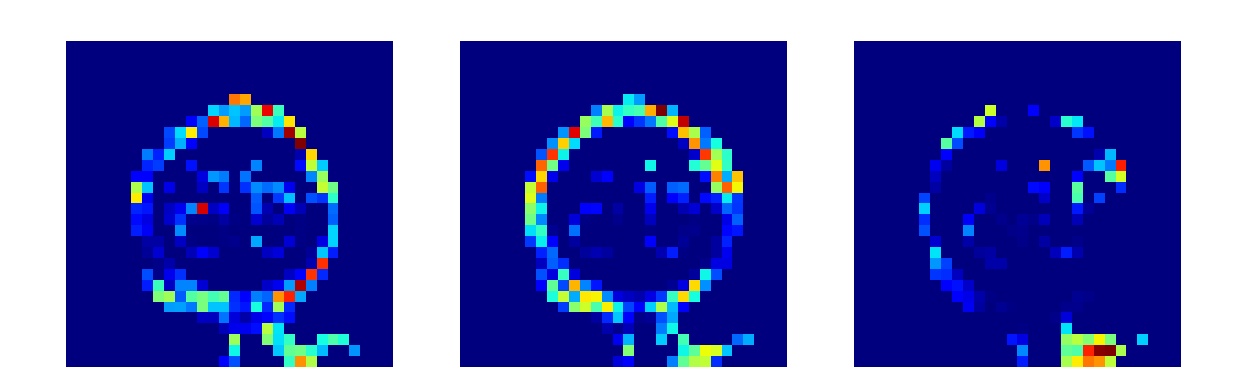

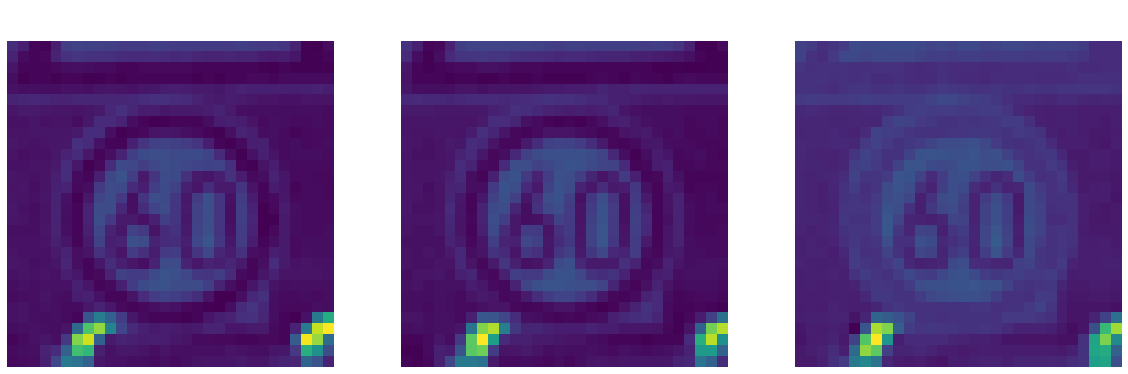

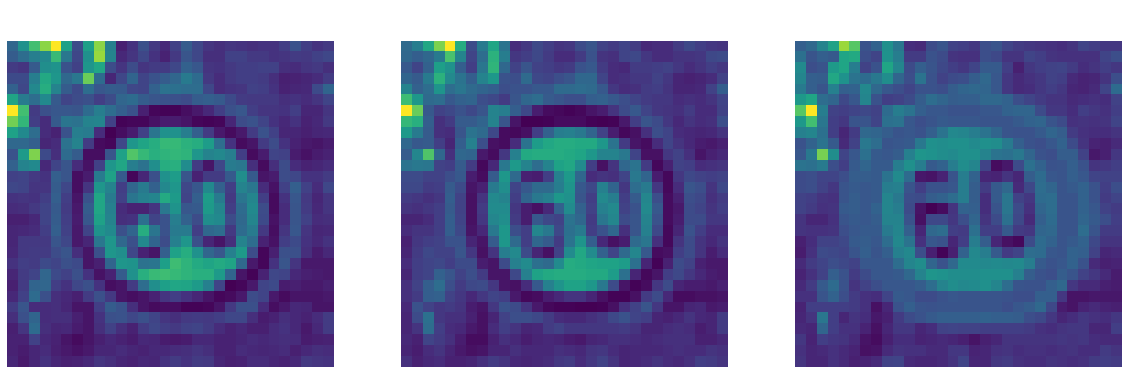

In [14]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap: https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

C_num = 3

# Separating Wrong Responses of the CNN Classifier
X_test_wrong, y_test_wrong = X_test[np.where(y_test != y_pred)], y_test[np.where(y_test != y_pred)]

# print(X_test_wrong.shape)

# Finding Wrong Decisions for Label 2 (just an example)
X_test_wrong3, y_test_wrong3 = X_test_wrong[np.where(y_test_wrong == C_num)], y_test_wrong[np.where(y_test_wrong == C_num)]

# print(X_test_wrong1.shape)

X_train3 = X_train[np.where(y_train[:,C_num] == 1)]

fig4, ax44 = pyplot.subplots(1,3, figsize = (20,6))
#fig5, ax55 = pyplot.subplots(1,3, figsize = (20,6))

for ii, c_ax44 in enumerate(ax44.flatten()):
    # Comparing X_train for Label == 2 with X_Test_wronge for Label == 2
    xxx, yyy= X_train3[:,:,:,ii], X_test_wrong3[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    
    WD = np.zeros(900)
    pVal = np.zeros(900)
      
    for kk in range(1, 900):
        WD[kk], pVal[kk] = Wasserstein_Dist_PVal(xxx_2[:30,kk], yyy_2[:30,kk]) 
        
    WD2 = WD    

    print(1 - WD2[WD2 != 0].mean())
    #print(1 - WD2.mean())
    
    WD3 = WD
    WD3[pVal > 0.05] = 0
    
    J,Q     = xxx_2.shape
    z       = WD3
    zstar   = pVal #WD.mean()
    z0      = np.zeros(Q)
    z0      = z
    z1      = z0.copy()
    #z1[np.abs(z1)<zstar] = 0
    Z0      = np.reshape(z1, (30,30))
    #Z0i     = Z0.copy()
    #Z0i[np.abs(Z0i)<zstar] = 0
    #ZZ      = np.hstack( [Z0, Z0i] )
    
    z2      = WD
    Z02      = np.reshape(z2, (30,30))
    
    c_ax44.imshow(Z0, 'jet') # Can be replaced with Z0i
    c_ax44.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax44.axis('off')
    
fig5, ax55 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax55 in enumerate(ax55.flatten()):
    c_ax55.imshow(X_train3[1,:,:,ii], interpolation = 'none')
    c_ax55.set_title('RGB: {} -- Test {}'.format(ii+1, 3))
    c_ax55.axis("off")
    
fig4, ax8 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax in enumerate(ax8.flatten()):
    c_ax.imshow(X_test_wrong3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test_wrong3[1]))
    c_ax.axis('off')    

<a id="wic"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Calculating Wilson Interval Confidence</b></div> 

In [15]:
# Kläs, M., & Sembach, L. (2019). Uncertainty wrappers for data-driven models. In International Conference on Computer Safety, Reliability, and Security. Springer.
from math import sqrt
def wilson(p, n, z = 3.29): # The z-score for a 95% confidence interval is 1.96.
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    
    return (lower_bound, upper_bound)


X_test_correct, y_test_correct = X_test[np.where(y_test == y_pred)], y_test[np.where(y_test == y_pred)]

X_test_correct3, y_test_correct3 = X_test_correct[np.where(y_test_correct == 3)], y_test_correct[np.where(y_test_correct == 3)]

print(X_test_correct3.shape[0])
print(X_test_wrong3.shape[0])

print(1 - X_test_wrong3.shape[0]/X_test_correct3.shape[0])

Negative = X_test_wrong3.shape[0] 
total = X_test_wrong3.shape[0] + X_test_correct3.shape[0] 
p  = 1 - Negative / total

print(wilson(p, total))

429
21
0.951048951048951
(0.9086504394002725, 0.9767199220890679)
